# Laboratorium 2


### Konfiguracja

In [1]:
from typing import List, Any, Union, Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

import random
from time import sleep

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in self.scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in self.scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    

### Przykład użycia

<IPython.core.display.Javascript object>


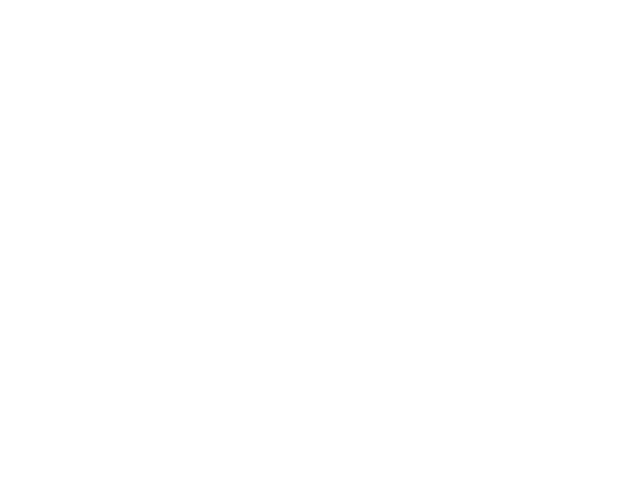

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], 'green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]], 'orange')]), 
        Scene([PointsCollection([(1, 2), (-15, 1.5), (2, -1)], 'red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], 'black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


### Klasa Vector reprezentuje podstawowy typ na którym wykonujemy obliczenia

In [4]:
from random import choice
from random import random

import math

class Vector:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def len(self):
        return math.sqrt(math.pow(self.x, 2) + math.pow(self.y, 2))

    def to_unit_vector(self):
        length = self.len()
        
        return Vector(self.x / length, self.y / length)
    
    def to_point(self):
        return self.x, self.y
    
    def subtract(self, other):
        return Vector(self.x - other.x, self.y - other.y)
        
    def add(self, other):
        return Vector(self.x + other.x, self.y + other.y)
        
    def scale(self, to_length):
        a = to_length / self.len()
        
        return Vector(a * self.x, a * self.y)
    
    def dot_product(self, other):
        return self.x * other.x + self.y * other.y
    

## Funkcje generujące zbiory z punktu 3.

In [5]:
def generate_point_on_line(pt_a: Vector, pt_b: Vector):
    if pt_b.x - pt_a.x == 0:
        r = math.fabs(pt_b.y - pt_a.y)
        
        x = pt_a.x
        y = min(pt_a.y, pt_b.y) + random() * r
        
        return Vector(x, y).to_point()   
    
    a = (pt_b.y - pt_a.y) / (pt_b.x - pt_a.x)
    b = pt_a.y - a * pt_a.x
    
    r = math.fabs(pt_b.x - pt_a.x)
    
    x = min(pt_a.x, pt_b.x) + random() * r
    y = a * x + b
        
    return Vector(x, y).to_point()

def random_set_a(n, lower, upper):
    points = []
    r = upper - lower
    
    for i in range(n):
        x = random() * r + lower
        y = random() * r + lower
        point = (x, y)
        
        points.append(point)
        
    return points

def random_set_b(n, center: Vector, radius):
    points = []
    
    for i in range(n):
        t = random() * 2 * math.pi
        x = radius * math.cos(t) + center.x
        y = radius * math.sin(t) + center.y
        
        point = (x, y)
        points.append(point)
        
    return points

def random_set_c(n, a: Vector, b: Vector, c: Vector, d: Vector):
    points = []
    possibilities = [(a, b), (b, c), (c, d), (a, d)]
         
    for i in range(n):
        (start, end) = choice(possibilities)        
        
        point = generate_point_on_line(start, end)
        points.append(point)
    
    return points

### This function takes only one vertex to identify a square - it's done to make sure we have points on axes.
def random_set_d(n_desc_diagonal, n_asc_diagonal, n_axis_x, n_axis_y, upper_right: Vector):
    lower_left = Vector(0.0, 0.0)
    upper_left = Vector(lower_left.x, upper_right.y)
    lower_right = Vector(upper_right.x, lower_left.y)
    
    points = [ lower_left.to_point(), lower_right.to_point(),
               upper_left.to_point(), upper_right.to_point() ]
        
    for i in range(n_axis_x):
        (a, b) = (lower_left, lower_right)
        point = generate_point_on_line(a, b)
        
        points.append(point)
        
    for i in range(n_axis_y):
        (a, b) = (lower_left, upper_left)
        point = generate_point_on_line(a, b)
        
        points.append(point)
        
    for i in range(n_desc_diagonal):
        (a, b) = (upper_left, lower_right)
        point = generate_point_on_line(a, b)
        
        points.append(point)
    
    for i in range(n_asc_diagonal):
        (a, b) = (lower_left, upper_right)
        point = generate_point_on_line(a, b)
        
        points.append(point)
    
    return points


## Zbiory z punktu 1.

In [6]:
points_a = random_set_a(100, -100, 100)
points_b = random_set_b(100, Vector(0, 0), 10)
points_c = random_set_c(100, Vector(-10, 10), Vector(-10, -10), Vector(10, -10), Vector(10, 10))
points_d = random_set_d(20, 20, 25, 25, Vector(10.0, 10.0))

### Graficzna wizualizacja wyznaczonych zbiorów - punkt 2.

<IPython.core.display.Javascript object>


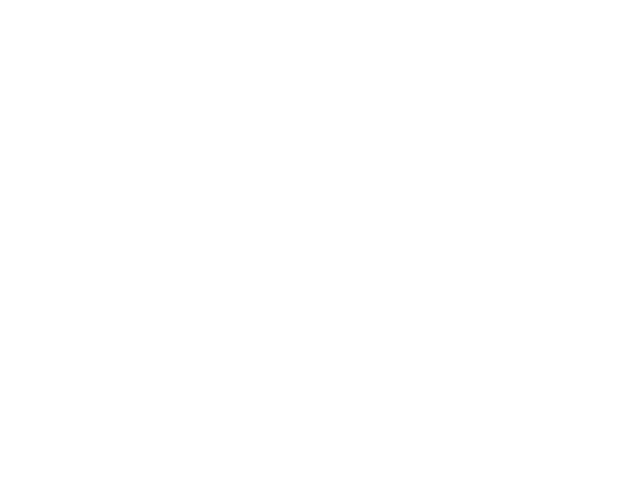

In [7]:
%matplotlib notebook

scenes = [
    Scene([PointsCollection(points_a)]),
    Scene([PointsCollection(points_b)]),
    Scene([PointsCollection(points_c)]),
    Scene([PointsCollection(points_d)]),
]

plot = Plot(scenes)
plot.draw()

## Implementacja algorytmów szukających otoczki wypukłej:
   - Algorytm Jarvisa
   - Algorytm Grahama


### Funkcje pomocniczne

In [8]:
import functools

def choose_lower_left(points):
    idx = 0
    p = points[idx]
    
    for (i, (x, y)) in enumerate(points):
        if (y < p[1]) or (y == p[1] and x < p[0]):   
            p = (x, y)
            idx = i
            
    return idx

def det(a, b, c):
    return a[0] * b[1] + a[1] * c[0] + b[0] * c[1] - b[1] * c[0] - a[0] * c[1] - a[1] * b[0]

def square_dist(a, b):
    return math.sqrt(math.pow(a[0] - b[0], 2) + math.pow(a[1] - b[1], 2))

INLINE = COLL = 0
LEFT = CCW = 1
RIGHT = CW = -1

def dist_sq(a, b):
    x1, y1 = a
    x2, y2 = b
    return (x1 - x2) ** 2 + (y1 - y2) ** 2

def det(a, b, c):
    (ax, ay) = a
    (bx, by) = b
    (cx, cy) = c
    return ax * by + ay * cx + bx * cy - by * cx - cy * ax - ay * bx

def orientation(a, b, c):
    d = det(a, b, c)
    if abs(d) < epsylon:
        return COLL
    return CCW if d > 0 else CW


def comparator(b, c, a, epsylon):
    d = det(a, b, c)
    diff = math.fabs(d - epsylon)
    
    if diff < epsylon:
        return square_dist(a, b) <= square_dist(a, c)
    else:
        return d > epsylon

### Graham

In [9]:
import time

def graham(points, eps):
    start = time.time()
    p0 = points[choose_lower_left(points)]
    
    ### $$$ FIXED SORTING $$$ ###
    def partition(points):
        pivot, *tail = points
        low, high = [], []
        ret_pivot = pivot
        for p in tail:
            d = orientation(p0, pivot, p)
            if d == INLINE:
                if dist_sq(p0, p) > dist_sq(p0, ret_pivot):
                    low.append(p)
                else:
                    high.append(p)
            elif d == CCW: high.append(p)
            else: low.append(p)
        return low, ret_pivot, high

    def quick_sort(points):
        if len(points) <= 1: return points
        low, pivot, high = partition(points)
        return quick_sort(low) + [pivot] + quick_sort(high)
    
    ### $$$ FIXED $$$ ###
    p1, p2, *left = quick_sort(points)
    
    stack = [p0, p1, p2]
    i, n = 0, len(left)
    
    while i < n:
        p = left[i]
        d = det(stack[-2], stack[-1], p)
        ### If to left with respect to line[stack[-2], stack[-1]]
        ### append p to stack
        if d > epsylon:
            stack.append(p)
            i = i + 1
        ## If collinear then pop and put point that is further on top of the stack
        elif d <= epsylon and d >= -epsylon:
            stack.pop()
            stack.append(p)
            i = i + 1
        ## If to right with respect to line[stack[-2], stack[-1]]
        ## This means we shouldn't have put top of the stack into convex_hull
        ## and we have to remove it.
        else:
            stack.pop()

    end = time.time()
    total = end - start

    return stack, total

### Jarvis

In [10]:
def jarvis(points, epsylon):
    start = time.time()
    N = choose_lower_left(points)
    convex_hull = []
    
    p = N
    
    while True:
        convex_hull.append(points[p])
        q = (p + 1) % len(points)
                
        for i, pnt in enumerate(points):
            if i != p and i != q:
                d = det(points[p], points[q], pnt)
                ### That means pnt is to the left with respect to line points[p], points[q] 
                ### <=> pnt should be checked whether or not he sould be in convex hull.
                if d < -epsylon:
                    q = i
                elif -epsylon <= d <= epsylon:
                    if square_dist(points[p], points[q]) < square_dist(points[p], pnt):
                        q = i
         
        p = q
        if p == N:
            break
            
    end = time.time()
    total = end - start
    
    return convex_hull, total

### Funkcje pomocnicze służące do wizualizacji:
- visualize: wyzancza otoczkę wpukłą używając najpierw Jarvisa następnie Grahama, wypisuje czasy działania.
- save: zapisuje wyznaczoną otoczkę 

In [11]:
%matplotlib notebook
import pickle

def connect_convex_hull(convex_hull):
    lines = []
    for k, end in enumerate(convex_hull):
        i = k - 1
        if k == 0:
            i = len(convex_hull) - 1
        
        start = convex_hull[i]
        lines.append([start, end])
        
    return lines

def get_lines(set):
    if len(set) < 2:
        return []
    
    lines = []
    for i, pt in enumerate(set[1:]):
        pnt = set[i]
        lines.append([pnt, pt])
    
    return lines

def create_scene(set, convex_hull):
    lines = connect_convex_hull(convex_hull)
    
    return Scene([
            PointsCollection(set, 'blue'),
            PointsCollection(convex_hull, 'red')
        ], [LinesCollection(lines, color="red")])
    
def visualize(set, epsylon):
    ch_jarvis, jarvis_time = jarvis(set, epsylon)
    ch_graham, graham_time = graham(set, epsylon)
    print("Jarvis: running time - {0}s \nGraham - running time - {1}s".format(jarvis_time, graham_time))
    
    jarvis_scene = create_scene(set, ch_jarvis)
    graham_scene = create_scene(set, ch_graham)
    scenes = [jarvis_scene, graham_scene]

    return scenes

def save(set, filename = "convex_hull"):
    with open(filename, 'wb') as handle:
        pickle.dump(set, handle, protocol = pickle.HIGHEST_PROTOCOL)

epsylon = 10 ** (-9)

### Testowanie wyników działania algorytmów 

Jarvis: running time - 0.0010421276092529297s 
Graham - running time - 0.0s


<IPython.core.display.Javascript object>


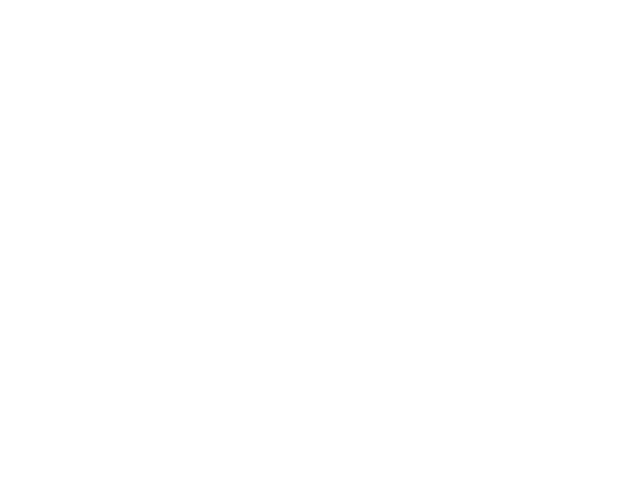

In [12]:
%matplotlib notebook

set = points_a
scenes = visualize(set, epsylon)

plot = Plot(scenes)
plot.draw()

Jarvis: running time - 0.006661415100097656s 
Graham - running time - 0.0s


<IPython.core.display.Javascript object>


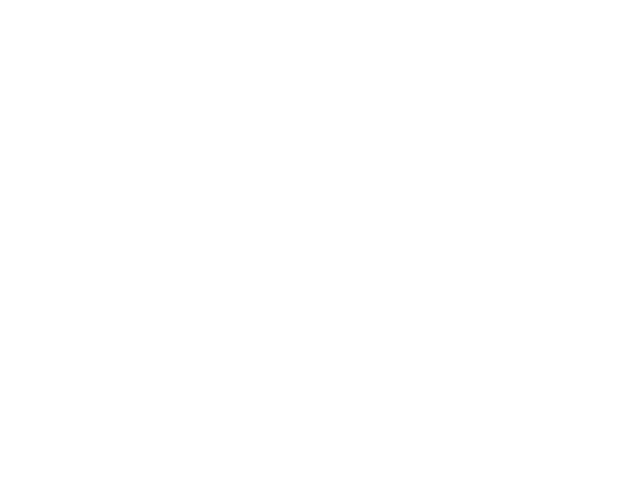

In [13]:
set = points_b
scenes = visualize(set, epsylon)

plot = Plot(scenes)
plot.draw()

Jarvis: running time - 0.0009720325469970703s 
Graham - running time - 0.0010225772857666016s


<IPython.core.display.Javascript object>


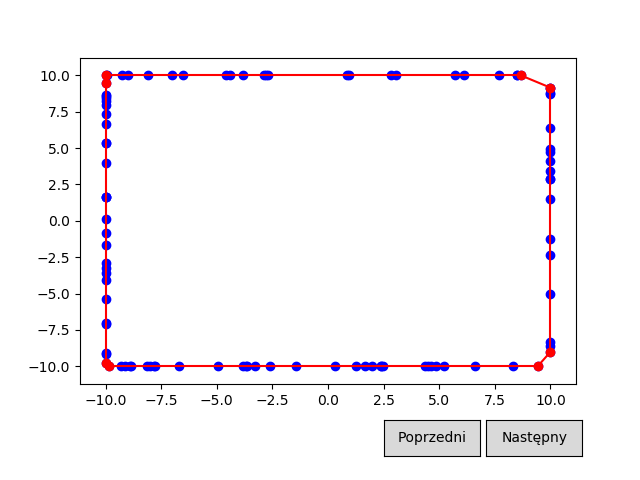

In [24]:
set = points_c
scenes = visualize(set, epsylon)

plot = Plot(scenes)
plot.draw()

Jarvis: running time - 0.0s 
Graham - running time - 0.0020189285278320312s


<IPython.core.display.Javascript object>


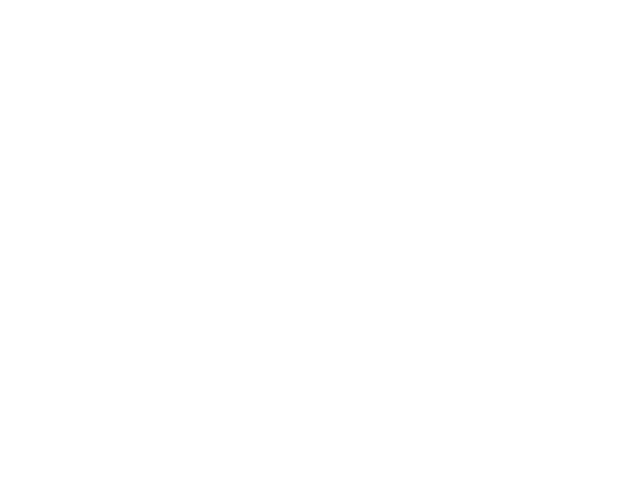

In [15]:
set = points_d
scenes = visualize(set, epsylon)

plot = Plot(scenes)
plot.draw()

### Dodatkowe zbiory

Jarvis: running time - 0.012965679168701172s 
Graham - running time - 0.012007713317871094s


<IPython.core.display.Javascript object>


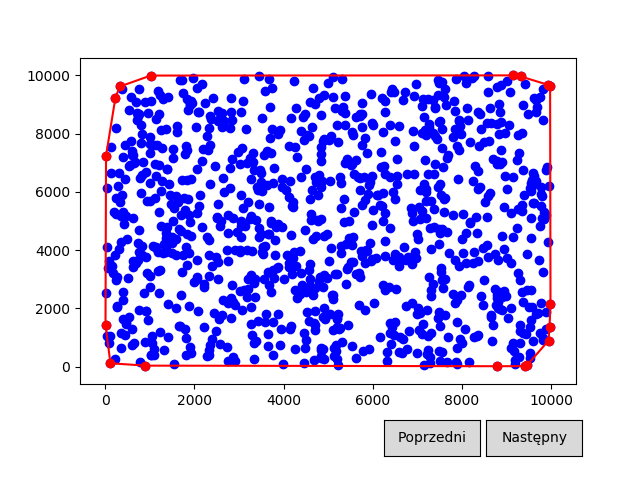

In [23]:
set = random_set_a(10 ** 3, 0.0, 10**4)
scenes = visualize(set, epsylon)

plot = Plot(scenes)
plot.draw()

### Metody pomocniczne służące do wizualizacji działania algorytmu

In [17]:
def visualize_jarvis(points, epsylon):
    N = choose_lower_left(points)
    convex_hull = []
    
    p = N
    pointsCollection = PointsCollection(points, 'gray')
    
    while True:
        convex_hull.append(points[p])
        q = (p + 1) % len(points)
                
        for i, pnt in enumerate(points):
            yield Scene([
                pointsCollection, PointsCollection(convex_hull, 'red')],
            [
                LinesCollection(get_lines(convex_hull), 'red'),
                LinesCollection([[points[p], points[q]]], 'orange'),
                LinesCollection([[points[q], points[i]]], 'yellow')
            ])
            
            if i != p and i != q:
                d = det(points[p], points[q], pnt)
                
                if d < -epsylon:
                    q = i
                elif -epsylon <= d <= epsylon:
                    if square_dist(points[p], points[q]) < square_dist(points[p], pnt):
                        q = i
         
        p = q
        if p == N:
            break
            
    yield Scene([pointsCollection, PointsCollection(convex_hull, 'red')], [
        LinesCollection(connect_convex_hull(convex_hull), 'red')
    ])

In [18]:
def visualize_graham(points, eps):
    p0 = points[choose_lower_left(points)]
    
    #2. Sort remaining points
    def partition(points):
        pivot, *tail = points
        low, high = [], []
        ret_pivot = pivot
        for p in tail:
            d = orientation(p0, pivot, p)
            if d == INLINE:
                if dist_sq(p0, p) > dist_sq(p0, ret_pivot):
                    high.append(p)
                else:
                    low.append(p)
            elif d == CCW: high.append(p)
            else: low.append(p)
        return low, ret_pivot, high

    def quick_sort(points):
        if len(points) <= 1:
            return points
        low, pivot, high = partition(points)
        return quick_sort(low) + [pivot] + quick_sort(high)
   
    p1, p2, *left = quick_sort(points) 
    stack = [p0, p1, p2]
    points_collection = PointsCollection(points, 'gray')
    i, n = 0, len(left)
    
    yield Scene([points_collection,
                 PointsCollection(stack, 'red'),
                PointsCollection([points[0]], 'yellow')])
    while i < n:
        p = left[i]
        yield Scene([
                points_collection,
                PointsCollection(stack, 'red'),
            ], [ 
                LinesCollection(get_lines(stack), 'red'),
                LinesCollection([[stack[-1], p]], 'orange')
            ])
        
        if det(stack[-2], stack[-1], p) > eps:
            stack.append(p)
            i = i + 1
        elif det(stack[-2], stack[-1], p) <= eps and det(stack[-2], stack[-1], p) >= -eps:
            stack.pop()
            stack.append(p)
            i = i + 1
        else:
            stack.pop()

    yield Scene([points_collection, PointsCollection(stack, 'red')], [
        LinesCollection(connect_convex_hull(stack), 'red')
    ])


## Wizualizacja działania aglorytmów

### Legenda
#### Punkty
- szare - punkty zbioru
- czerwone - należące do otoczki
#### Linie
- czerwona - łącząca punkty wyznacznej otoczki
- pomarańczowa - potencjalna krawędź otoczki
- żółta - krawędź łączące aktualnie sprawdzane punkty


<IPython.core.display.Javascript object>


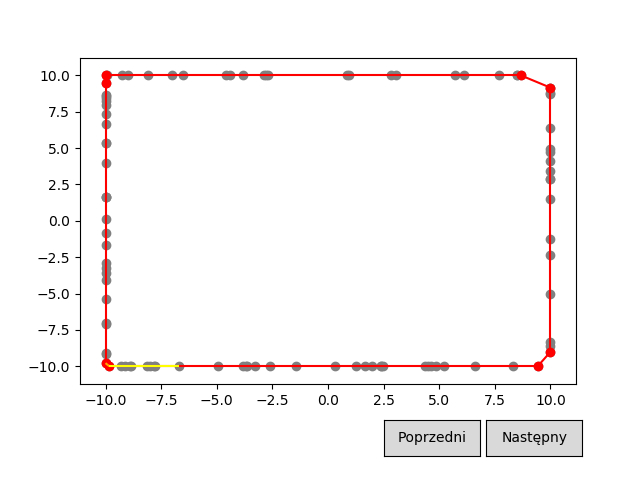

In [22]:
generator = visualize_jarvis(points_c, epsylon)
scenes = list(generator)

plot = Plot(scenes)
plot.draw()


<IPython.core.display.Javascript object>


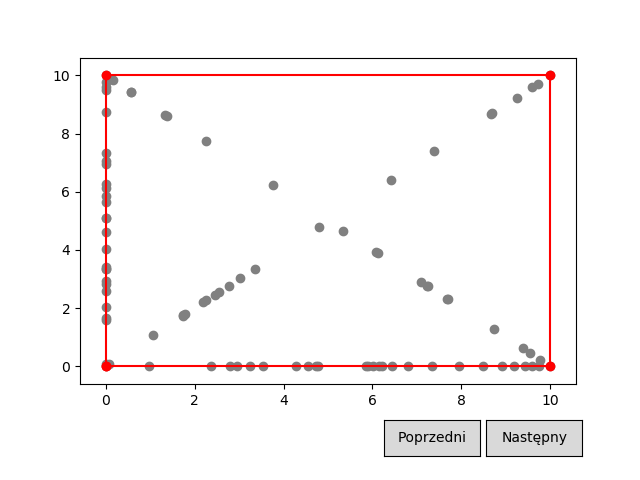

In [21]:
generator = visualize_graham(points_d, epsylon)
scenes = list(generator)

plot = Plot(scenes)
plot.draw() 